In [1]:
import MBS_analysis as mbs
import pandas as pd
import pickle
import matplotlib as plt
%matplotlib inline
import numpy as np
from multiprocessing import Pool
import importlib
importlib.reload(mbs)

<module 'MBS_analysis' from '/Users/poyda/Projects/GP-networks/py/MBS_analysis.py'>

# 1. From raw-data to hierarchical blockmodels
This happens in the four steps below. For details, see the module `MBS_analysis`.

### Raw data $\to$ pandas data frame

Read the first 800,000 rows from the dataset for 2014:

In [5]:
df = mbs.make_df("../data-raw/800000.csv", nrows = 800000)

### data frame $\to$ bipartite graph

Create the doctor-patient graph from these rows: 

In [ ]:
g = mbs.patient_doctor_graph(df)

Save the graph for later.

In [ ]:
import pickle
with open("../pickle/graphs/800000.p", 'wb') as fo:
    pickle.dump(g, fo)

### bipartite graph $\to$ hierarchical blockmodel

Load the graph.

In [ ]:
import pickle
with open("../pickle/graphs/800000.p", 'rb') as fo:
    g = pickle.load(fo)

Fit a hierarchical blockmodel `state`, e.g. to Region 1. 

In [ ]:
state = mbs.blockmodel(g, [1])

### hierarchical blockmodel $\to$ extract PPCs

Divide the bottom layer into its connected components:

In [ ]:
state = mbs.extract_PPCs(state)

The `NestedBlockState` object contains the PPCs at the lowest level. Save it:

In [ ]:
with open("../pickle/blockmodels/800000.p", 'wb') as save_to:
    pickle.dump(state, save_to, -1)

# 2. Blockmodels for entire regions

We load one state for each region, pre-calculated on UNSW katana high-performance-computing cluster. (See the scripts in the `pbs` folder.)

In [ ]:
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2014.csv.p1", 'rb') as fo:
    state1 = pickle.load(fo)

In [ ]:
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2014.csv.p2", 'rb') as fo:
    state2 = pickle.load(fo)

In [ ]:
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2014.csv.p3", 'rb') as fo:
    state3 = pickle.load(fo)

In [2]:
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2014.csv.p4", 'rb') as fo:
    state4 = pickle.load(fo)

In [82]:
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2014.csv.p5", 'rb') as fo:
    state5 = pickle.load(fo)

Internally, the blocks are indexed by numbers. The indices for the blocks on the lowest level which are PPCs (made up of doctors and not patients) are extracted below. (We only display the first 20 for Region 3.)

In [127]:
mbs.PPCids(state2)[:20]

PropertyArray([ 0,  1,  2,  3,  7,  8, 10, 11, 12, 14, 16, 17, 20, 21, 22,
               23, 25, 29, 30, 32], dtype=int32)

### Number of PPCs

How many PPCs has our algorithm identified in 2009?

In [379]:
sum(list(map(lambda x: len(mbs.PPCids(x)), states)))

6705

### Statistics on PPC sizes

Calculate the `sizes` of all PPCs and plot the histogram. Below this is done for Region 3. 

In [144]:
def get_PPC_size(k):
    g = mbs.PPCgraph(states[2],k)
    return(sum(g.vp.doctor.a))

with Pool(4) as p:
    sizes = p.map(get_PPC_size, range(len(mbs.PPCids(states[2]))))

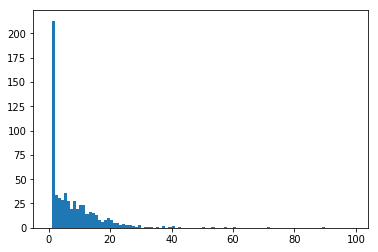

In [145]:
h = plt.pyplot.hist(sizes, bins=range(0,100))

The fraction of PPCs of size 1, 2-6 and 7+ are:

In [146]:
sizes126 = np.array([np.bincount(sizes)[1], sum(np.bincount(sizes)[range(2,7)]), sum(np.bincount(sizes)[7:])])
sizes126 / sum(sizes126)

array([0.34025559, 0.25239617, 0.40734824])

# 3. GP, patient and PPC properties
### Patient properties

For the entire graph (below, Region 3 in 2009), calculate: 
* `upc`: usual provider continuity. This is defined as $\max\{n_i\} / \sum n_i$, where $n_i$ are the numbers of visits of a patient to a distinct _provider_. 
* `upppc`: usual PPC continuity. This is defined similarly as `upc`, except that the $n_i$'s denote numbers of visits to distinct _PPCs_.

### GP properties

* `apt`: average patient time, a doctor property. This is defined as the degree of a doctor, weighted with the number of visits, divided by the sum of the weighted degrees of all her patients. It represents the weighted average fraction of visits that a doctor's patients are allocating to her.

### PPC properties measuring connectedness

* `ppd`: patient degree in PPC. For each patient in a PPC-centric graph, calculate their degree and average it within the PPC.
* `spf`: For each GP, the fraction of shared patients, and averaged within the PPC

`add_props` adds the properties to the underlying graphs:

In [83]:
with Pool() as p:
    aug_states = p.map(mbs.add_props, [state1, state2, state3, state4, state5])

Patient normalized visits done.
Patient normalized visits done.
Patient normalized visits done.
Patient normalized visits done.
Usual provider continuity, Usual PPC continuity and Average Patient Time done.
Shared patient fraction and PPC patient degree done.
Patient normalized visits done.
Usual provider continuity, Usual PPC continuity and Average Patient Time done.
Usual provider continuity, Usual PPC continuity and Average Patient Time done.
Usual provider continuity, Usual PPC continuity and Average Patient Time done.
Usual provider continuity, Usual PPC continuity and Average Patient Time done.
Shared patient fraction and PPC patient degree done.
Shared patient fraction and PPC patient degree done.
Shared patient fraction and PPC patient degree done.
Shared patient fraction and PPC patient degree done.


Save:

In [84]:
for s, fn in zip(aug_states, ["state1.p", "state2.p", "state3.p", "state4.p", "state5.p"]): 
    with open("../pickle/blockmodels/" + fn, 'wb') as fo:
        pickle.dump(s, fo)

Calculate / extract the properties for each PPC:

In [94]:
with Pool() as p:
    ppc_stats = p.map(mbs.get_ppc_stats, aug_states)

In [315]:
with open("../pickle/other/2014stats.p", 'wb') as fo:
    pickle.dump(ppc_stats, fo)

`ppc_stats` is a data frame with the columns
1. mean `spf` (shared patient fraction)
2. mean `ppd` (patient degree in PPC)
1. mean `upc` (usual provider continuity)
2. mean `uppcc` (usual PPC continuity)
3. mean `apt` (average patient time)
4. mean doctor degree (not weighted by visits). 

The mean is taken over all patients or GPs within a PPC. 

Remove solo GPs:

In [139]:
ppc_stats[ppc_stats['ppd'] != 1]

spf   ppd   upc  uppcc   apt     deg
reg1 0    0.73  1.74  0.61   0.78  0.23  135.88
     1    0.55  1.48  0.55   0.70  0.14   96.00
     4    0.26  1.04  0.62   0.73  0.15   40.00
     6    0.70  1.75  0.73   0.90  0.33  104.40
     7    0.08  1.03  0.73   0.78  0.53  150.50
     8    0.13  1.05  0.58   0.69  0.20   53.70
     9    0.77  1.67  0.77   0.93  0.27   90.67
     10   0.48  1.09  0.76   0.80  0.41   15.71
     11   0.80  2.13  0.61   0.84  0.24   38.91
     12   0.63  1.55  0.67   0.83  0.34  102.50
     14   0.03  1.02  0.76   0.78  0.58  158.50
     17   0.44  1.32  0.66   0.74  0.34  203.75
     18   0.80  1.94  0.59   0.77  0.20  160.29
     19   0.67  1.79  0.65   0.83  0.28   63.29
     21   0.69  1.44  0.78   0.88  0.30   97.00
     22   0.75  1.96  0.69   0.91  0.33  121.64
     23   0.84  1.59  0.58   0.78  0.20   26.60
     25   0.71  1.47  0.59   0.74  0.18   65.60
     27   0.74  1.77  0.65   0.84  0.27   80.56
     28   0.65  1.82  0.52   0.68  0.16   63.50
     29   0.80  2.15  0.59   0.83  0.22  102.67
     31   0.11  1.06  0.58   0.71  0.18   37.40
     32   0.85  2.43  0.56   0.84  0.20   68.69
     33   0.35  1.20  0.67   0.74  0.40  242.50
     34   0.74  1.98  0.55   0.77  0.20  106.68
     35   0.22  1.14  0.82   0.88  0.65   93.50
     36   0.12  1.04  0.62   0.73  0.19  112.00
     37   0.59  1.46  0.70   0.82  0.34   61.00
     39   0.64  1.22  0.72   0.79  0.29   63.00
     40   0.54  1.43  0.59   0.70  0.26  247.20
...        ...   ...   ...    ...   ...     ...
reg5 694  0.64  1.56  0.69   0.86  0.35  193.38
     697  0.71  1.15  0.75   0.80  0.30   41.25
     698  0.81  1.98  0.63   0.85  0.26  128.00
     700  0.46  1.06  0.71   0.78  0.32   53.50
     701  0.65  1.77  0.68   0.86  0.30  172.00
     702  0.75  2.10  0.57   0.81  0.20   89.79
     703  0.27  1.04  0.85   0.87  0.58  189.00
     704  0.73  1.72  0.63   0.81  0.26  105.69
     705  0.56  1.44  0.70   0.82  0.29  121.83
     706  0.65  1.50  0.70   0.83  0.31   93.00
     707  0.69  1.63  0.55   0.73  0.22   25.57
     708  0.50  1.09  0.83   0.86  0.43   60.00
     709  0.02  1.01  0.57   0.66  0.22  112.00
     711  0.56  1.59  0.69   0.84  0.34   81.30
     712  0.78  1.96  0.61   0.81  0.22  102.40
     713  0.70  1.68  0.69   0.87  0.35  181.21
     714  0.72  1.79  0.61   0.81  0.24  245.89
     715  0.72  1.68  0.71   0.87  0.37  106.43
     718  0.64  1.54  0.73   0.88  0.33  137.33
     721  0.71  1.63  0.70   0.85  0.37  109.50
     722  0.57  1.45  0.74   0.86  0.38   65.90
     723  0.79  2.29  0.58   0.85  0.19   24.12
     724  0.72  1.53  0.68   0.83  0.27  103.56
     725  0.57  1.47  0.68   0.83  0.37  148.67
     727  0.21  1.13  0.60   0.69  0.22   97.75
     728  0.68  1.66  0.67   0.85  0.34  136.88
     729  0.53  1.05  0.85   0.88  0.74   10.00
     732  0.70  1.70  0.59   0.77  0.26   90.00
     734  0.63  1.27  0.75   0.84  0.39   53.27
     735  0.70  1.54  0.60   0.75  0.23  152.60

[5244 rows x 6 columns]

Plot correlations of properties: 

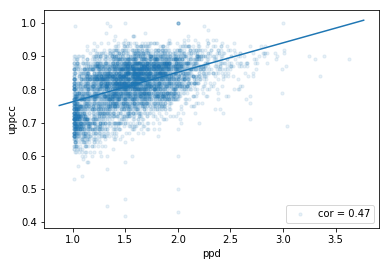

In [343]:
x_var = 'ppd'
y_var = 'uppcc'
x = ppc_stats[ppc_stats['ppd'] != 1][x_var]
y = ppc_stats[ppc_stats['ppd'] != 1][y_var]

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

import matplotlib.pyplot as plt
plt.scatter(x,
            y, 
            s = 10, 
           alpha = 0.1, 
           label = 'cor = '+str(np.round(r_value, 2)))
plt.xlabel(x_var)
plt.ylabel(y_var)
x_line = np.array(plt.gca().get_xlim())
y_line = intercept + slope * x_line
plt.plot(x_line, y_line)
plt.legend()

# 4. Plotting PPCs

Plot all PPCs in a given region, e.g. Region 4: 

In [6]:
s = state4
def k_to_plot(k):
    g = mbs.PPCgraph(s, k)
    mbs.plot_PPCgraph(g, output=str(k)+'.png')

with Pool() as p:
    p.map(k_to_plot, range(len(mbs.PPCids(s))))

### PPCs to put into paper
We look at tightly and loosely knit communities, for PPCs of varying sizes; see the following plots. 
At the end, we give a table of PPC stats, where the columns are as above. 
It can be seen that for the "tighter" communities (rows 1,3,5) the `upc` value is lower than for the looser communities (rows 2,4,6). But the `uppcc` values are comparable, and in fact higher for the tighter communities. 

In [25]:
with open("../pickle/other/2014stats.p", 'rb') as fo:
    ppc_stats = pickle.load(fo).loc['reg4']

In [119]:
pick_k_dense = [1445, 213, 61]

1445


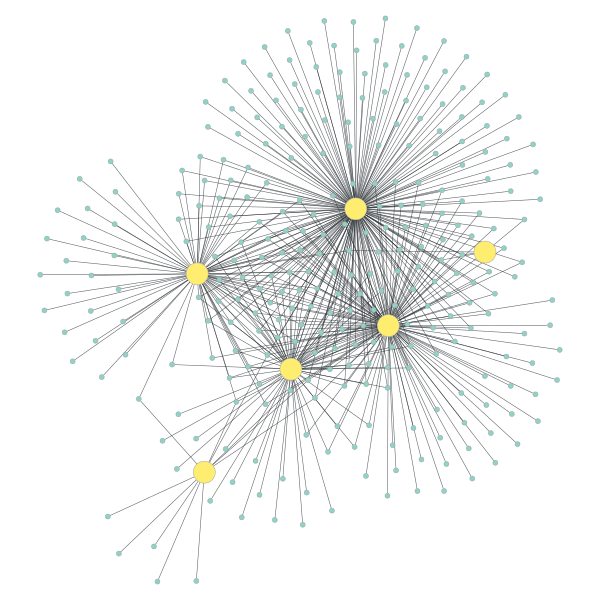

213


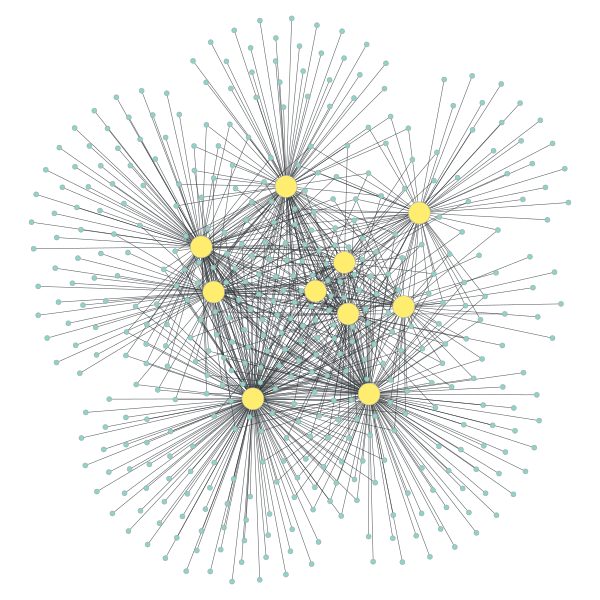

61


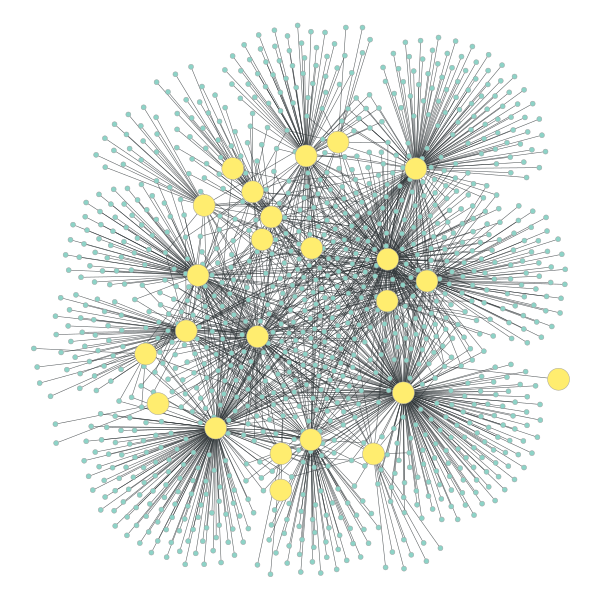

In [120]:
for k in pick_k_dense:
    print(k)
    mbs.plot_PPCgraph(mbs.PPCgraph(s, k))

In [144]:
pick_k_loose = [688, 1201, 1101]

688


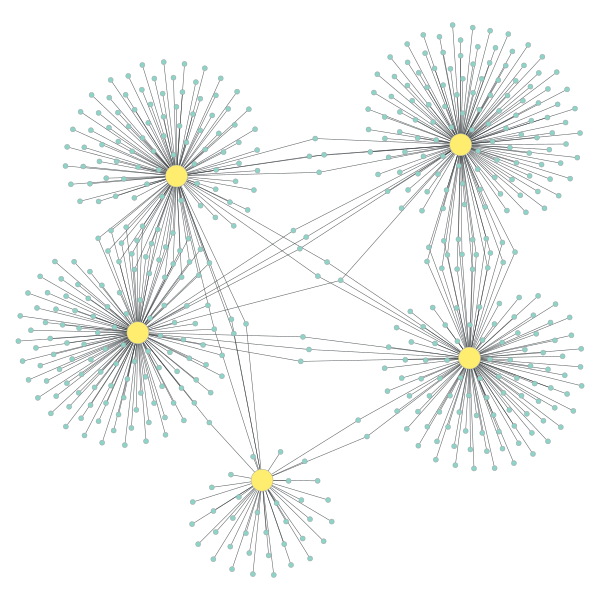

1201


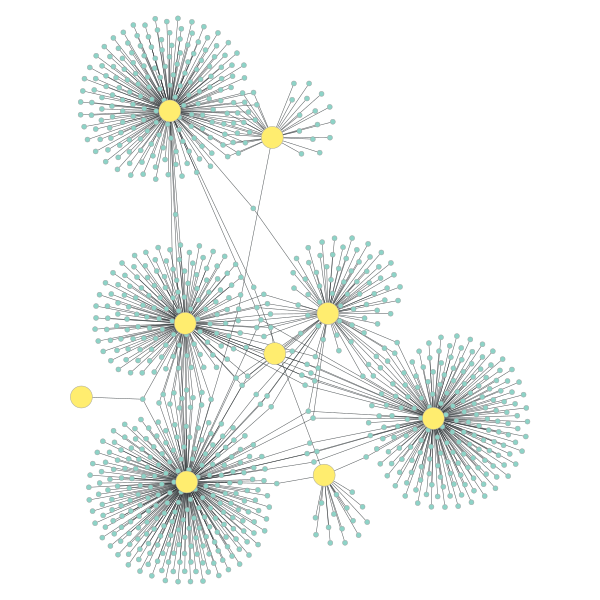

1101


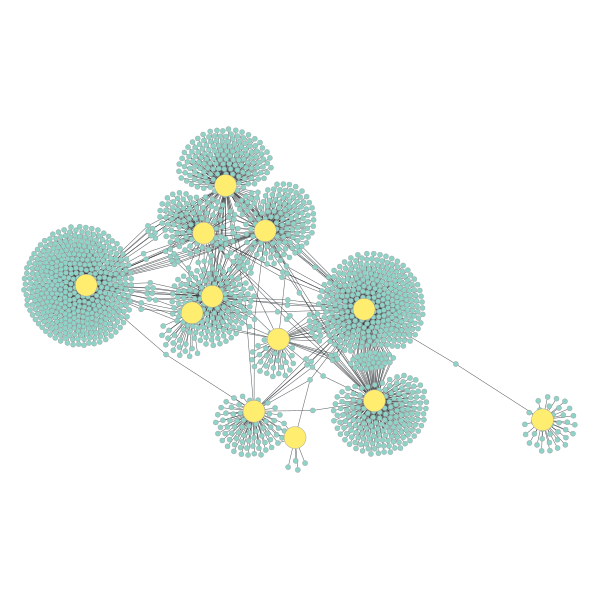

In [145]:
for k in pick_k_loose:
    print(k)
    mbs.plot_PPCgraph(mbs.PPCgraph(s, k))

In [148]:
[ppc_stats.loc[k] for k in pick_k_dense + pick_k_loose]

[spf       0.75
 ppd       1.80
 upc       0.54
 uppcc     0.76
 apt       0.19
 deg      87.50
 Name: 1445, dtype: float64, spf       0.79
 ppd       2.03
 upc       0.54
 uppcc     0.75
 apt       0.18
 deg      88.50
 Name: 213, dtype: float64, spf       0.65
 ppd       1.56
 upc       0.53
 uppcc     0.69
 apt       0.17
 deg      70.50
 Name: 61, dtype: float64, spf        0.22
 ppd        1.13
 upc        0.70
 uppcc      0.76
 apt        0.47
 deg      112.40
 Name: 688, dtype: float64, spf        0.38
 ppd        1.11
 upc        0.65
 uppcc      0.73
 apt        0.24
 deg      108.11
 Name: 1201, dtype: float64, spf        0.27
 ppd        1.12
 upc        0.63
 uppcc      0.72
 apt        0.22
 deg      160.17
 Name: 1101, dtype: float64]